# Prestazioni

Sono state fatte due analisi

- Prestazioni al variare del numero di individui generati.
- Prestazioni al variare del numero di feature che compongono i dati.


In [3]:
import pandas as pd

rf = pd.read_csv("../results/performance/ppga_RandomForestClassifier_pop_final3.csv")
mlp = pd.read_csv("../results/performance/ppga_MLPClassifier_pop_final4.csv")
svm = pd.read_csv("../results/performance/ppga_SVC_pop_final3.csv")

ppga_df = pd.concat([rf, mlp, svm], axis=0)
ppga_df = (
    ppga_df.groupby(by=["classifier", "population_size", "workers"])
    .mean()[["time", "ptime"]]
    .reset_index()
)

ppga_df

,classifier,population_size,workers,time,ptime
0,MLPClassifier,1000,1,1.696748,1.461996
1,MLPClassifier,1000,2,1.352881,0.950110
2,MLPClassifier,1000,4,0.841245,0.521793
3,MLPClassifier,1000,8,1.009742,0.546543
4,MLPClassifier,1000,16,1.290943,0.589217
...,...,...,...,...,...
85,SVC,16000,2,27.793731,22.100000
86,SVC,16000,4,17.904491,11.632500
87,SVC,16000,8,12.419058,6.085000
88,SVC,16000,16,10.229195,3.995000


In [4]:
def compute_speedup(df, field):
    speed_up = []
    for model in df["classifier"].unique():
        for ps in df["population_size"].unique():
            mask1 = (
                (df["classifier"] == model)
                & (df["population_size"] == ps)
                & (df["workers"] == 1)
            )
            a1 = df[mask1][field].to_numpy()
            for w in df["workers"].unique():
                mask = (
                    (df["classifier"] == model)
                    & (df["population_size"] == ps)
                    & (df["workers"] == w)
                )
                a = df[mask][field].to_numpy()
                speed_up.append((a1 / a)[0])
            # print(speed_up[-1])
    if field == "time":
        df["speed_up"] = pd.Series(speed_up)
    else:
        df["p_speed_up"] = pd.Series(speed_up)

    return df


ppga_df = compute_speedup(ppga_df, "time")
ppga_df = compute_speedup(ppga_df, "ptime")
ppga_df

,classifier,population_size,workers,time,ptime,speed_up,p_speed_up
0,MLPClassifier,1000,1,1.696748,1.461996,1.000000,1.000000
1,MLPClassifier,1000,2,1.352881,0.950110,1.254174,1.538765
2,MLPClassifier,1000,4,0.841245,0.521793,2.016950,2.801871
3,MLPClassifier,1000,8,1.009742,0.546543,1.680377,2.674986
4,MLPClassifier,1000,16,1.290943,0.589217,1.314348,2.481253
...,...,...,...,...,...,...,...
85,SVC,16000,2,27.793731,22.100000,3.156276,1.887514
86,SVC,16000,4,17.904491,11.632500,4.899591,3.585992
87,SVC,16000,8,12.419058,6.085000,7.063715,6.855226
88,SVC,16000,16,10.229195,3.995000,8.575913,10.441565


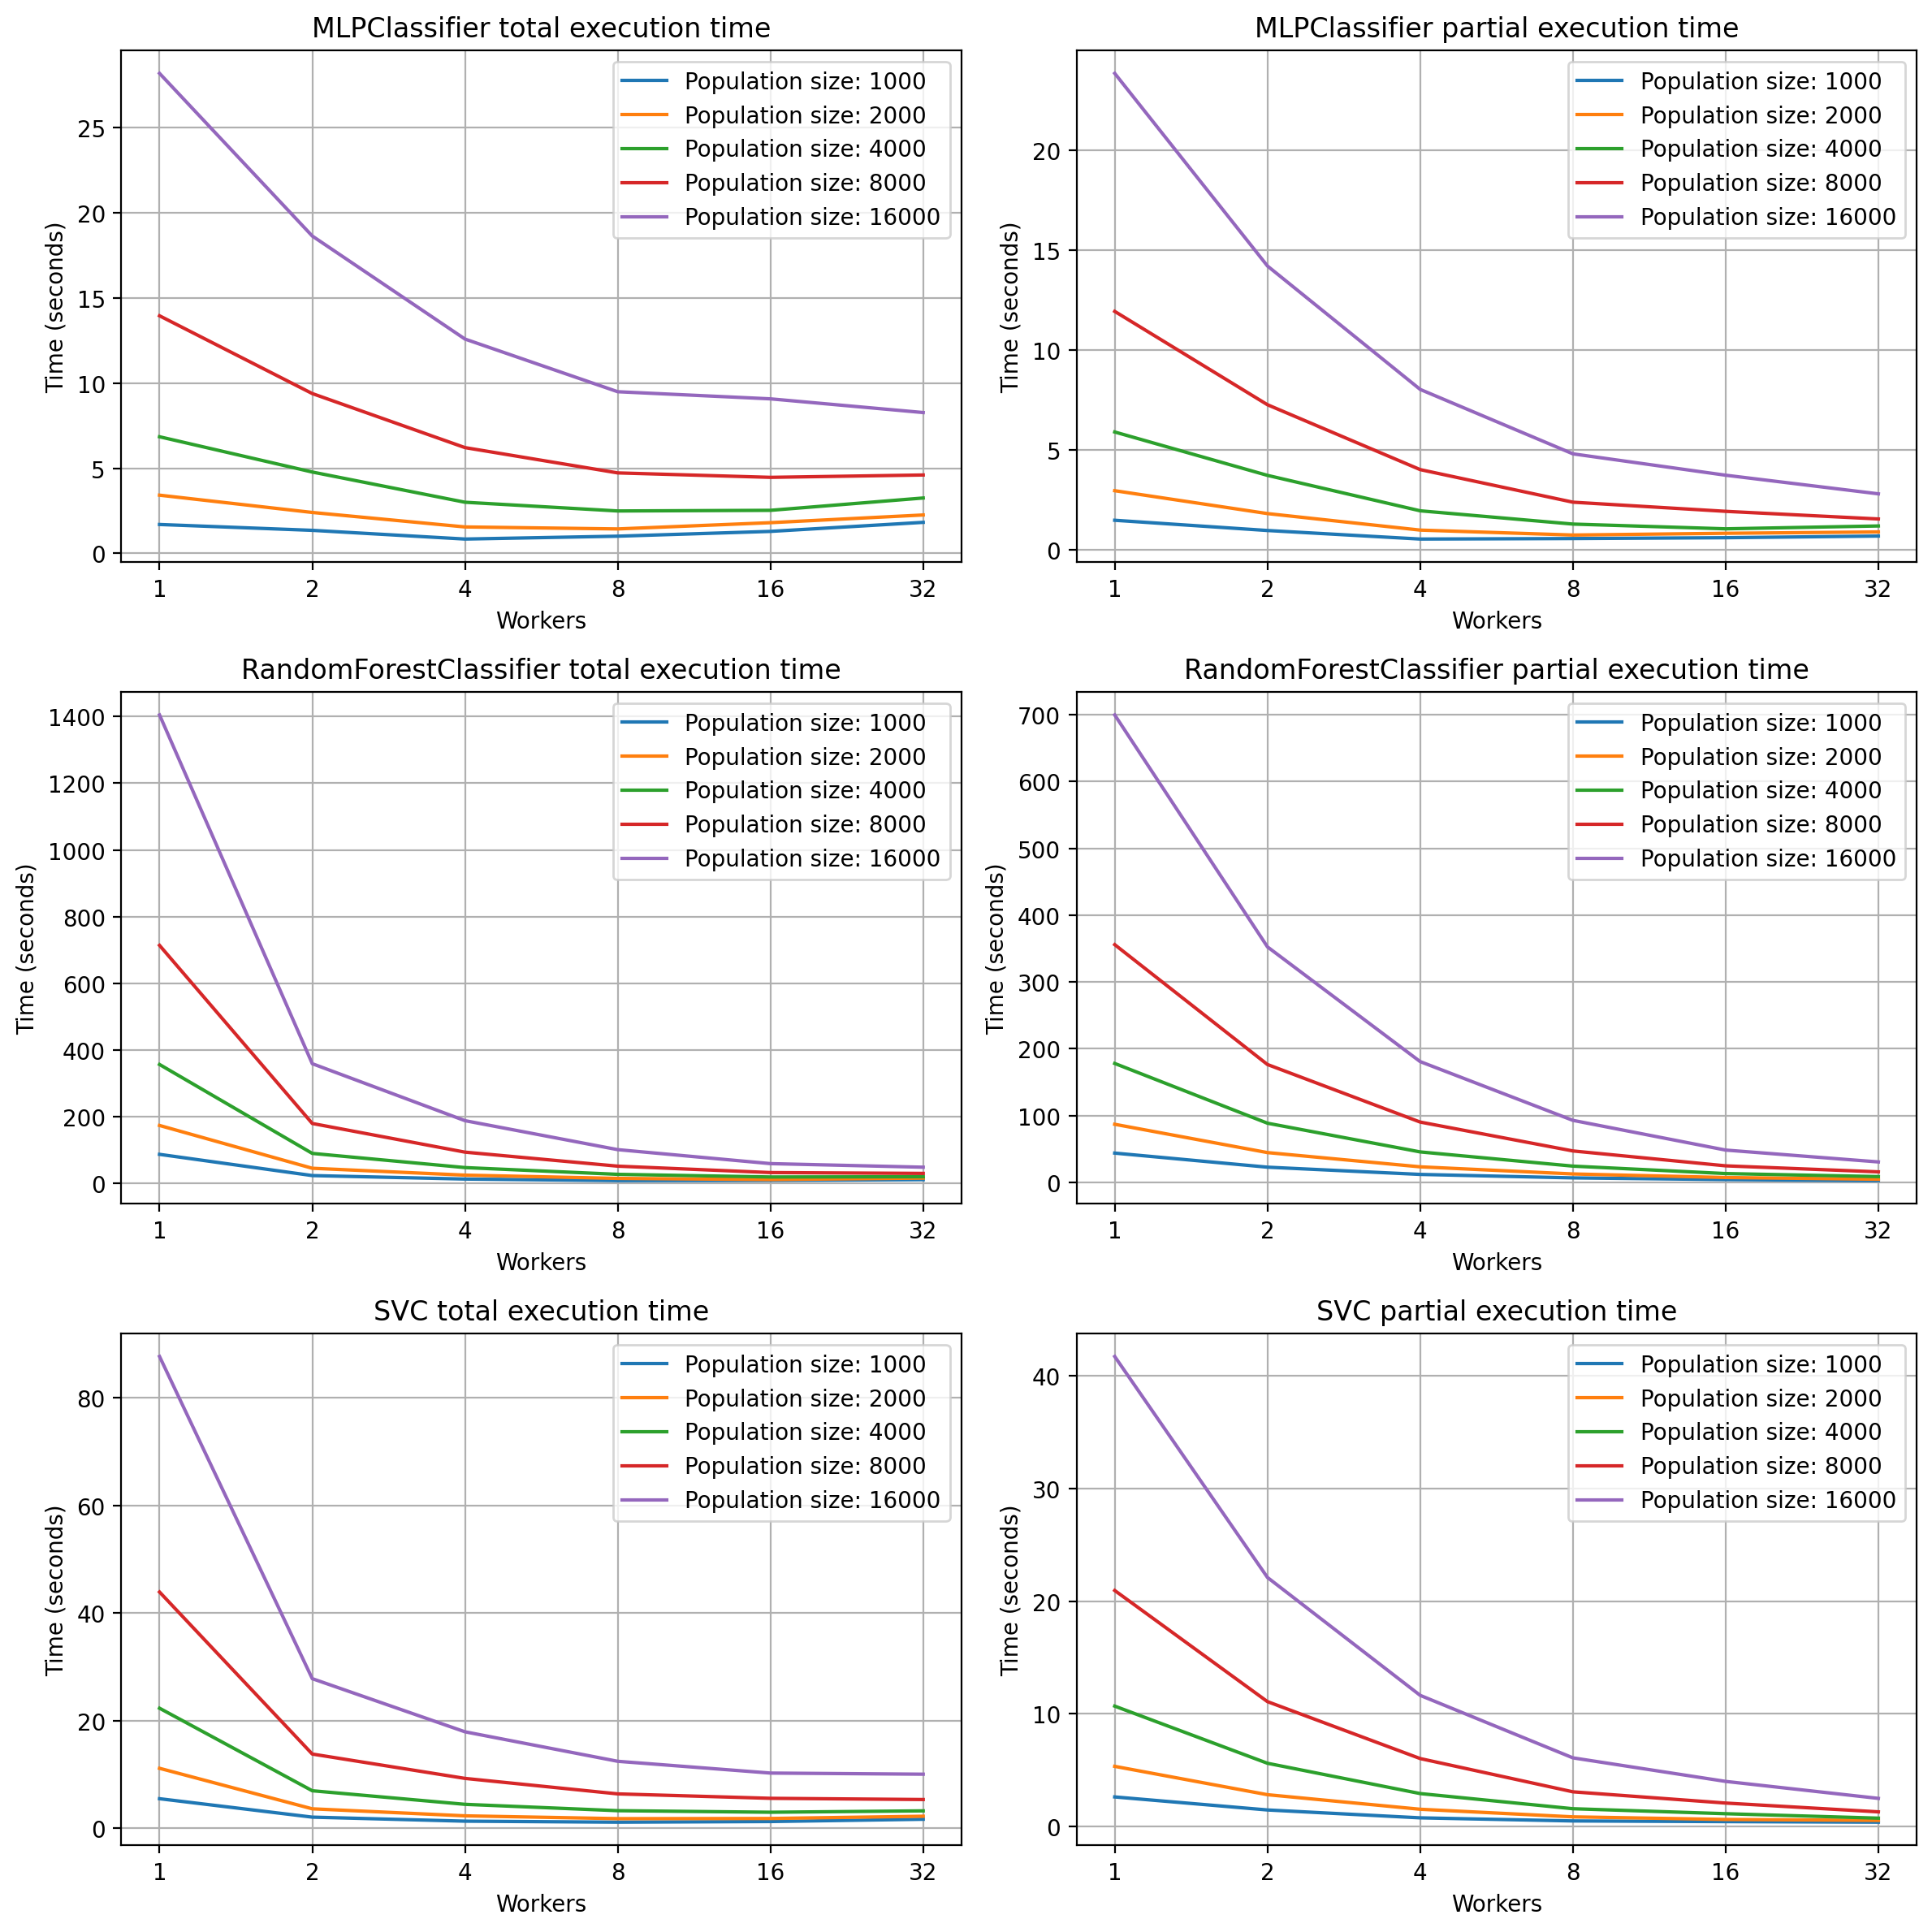

In [5]:
import matplotlib.pyplot as plt
import numpy as np


def plot_time(df):
    models = df["classifier"].unique()
    workers = df["workers"].unique()
    population_sizes = df["population_size"].unique()

    fig, axes = plt.subplots(len(models), 2, figsize=(12, 12), dpi=200)

    for i, model in enumerate(models):
        for ps in population_sizes:
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            axes[i, 0].set_title(f"{model} total execution time")
            axes[i, 0].set_xlabel("Workers")
            axes[i, 0].set_ylabel("Time (seconds)")
            axes[i, 0].plot(
                workers,
                df[mask]["time"].values,
                label=f"Population size: {ps}",
            )

            axes[i, 0].set_xscale("log", base=2)
            axes[i, 0].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i, 0].grid()
            axes[i, 0].legend()

            axes[i, 1].set_title(f"{model} partial execution time")
            axes[i, 1].set_xlabel("Workers")
            axes[i, 1].set_ylabel("Time (seconds)")
            axes[i, 1].plot(
                workers,
                df[mask]["ptime"].values,
                label=f"Population size: {ps}",
            )

            axes[i, 1].set_xscale("log", base=2)
            axes[i, 1].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i, 1].grid()
            axes[i, 1].legend()

    plt.tight_layout()
    plt.show()


plot_time(ppga_df)

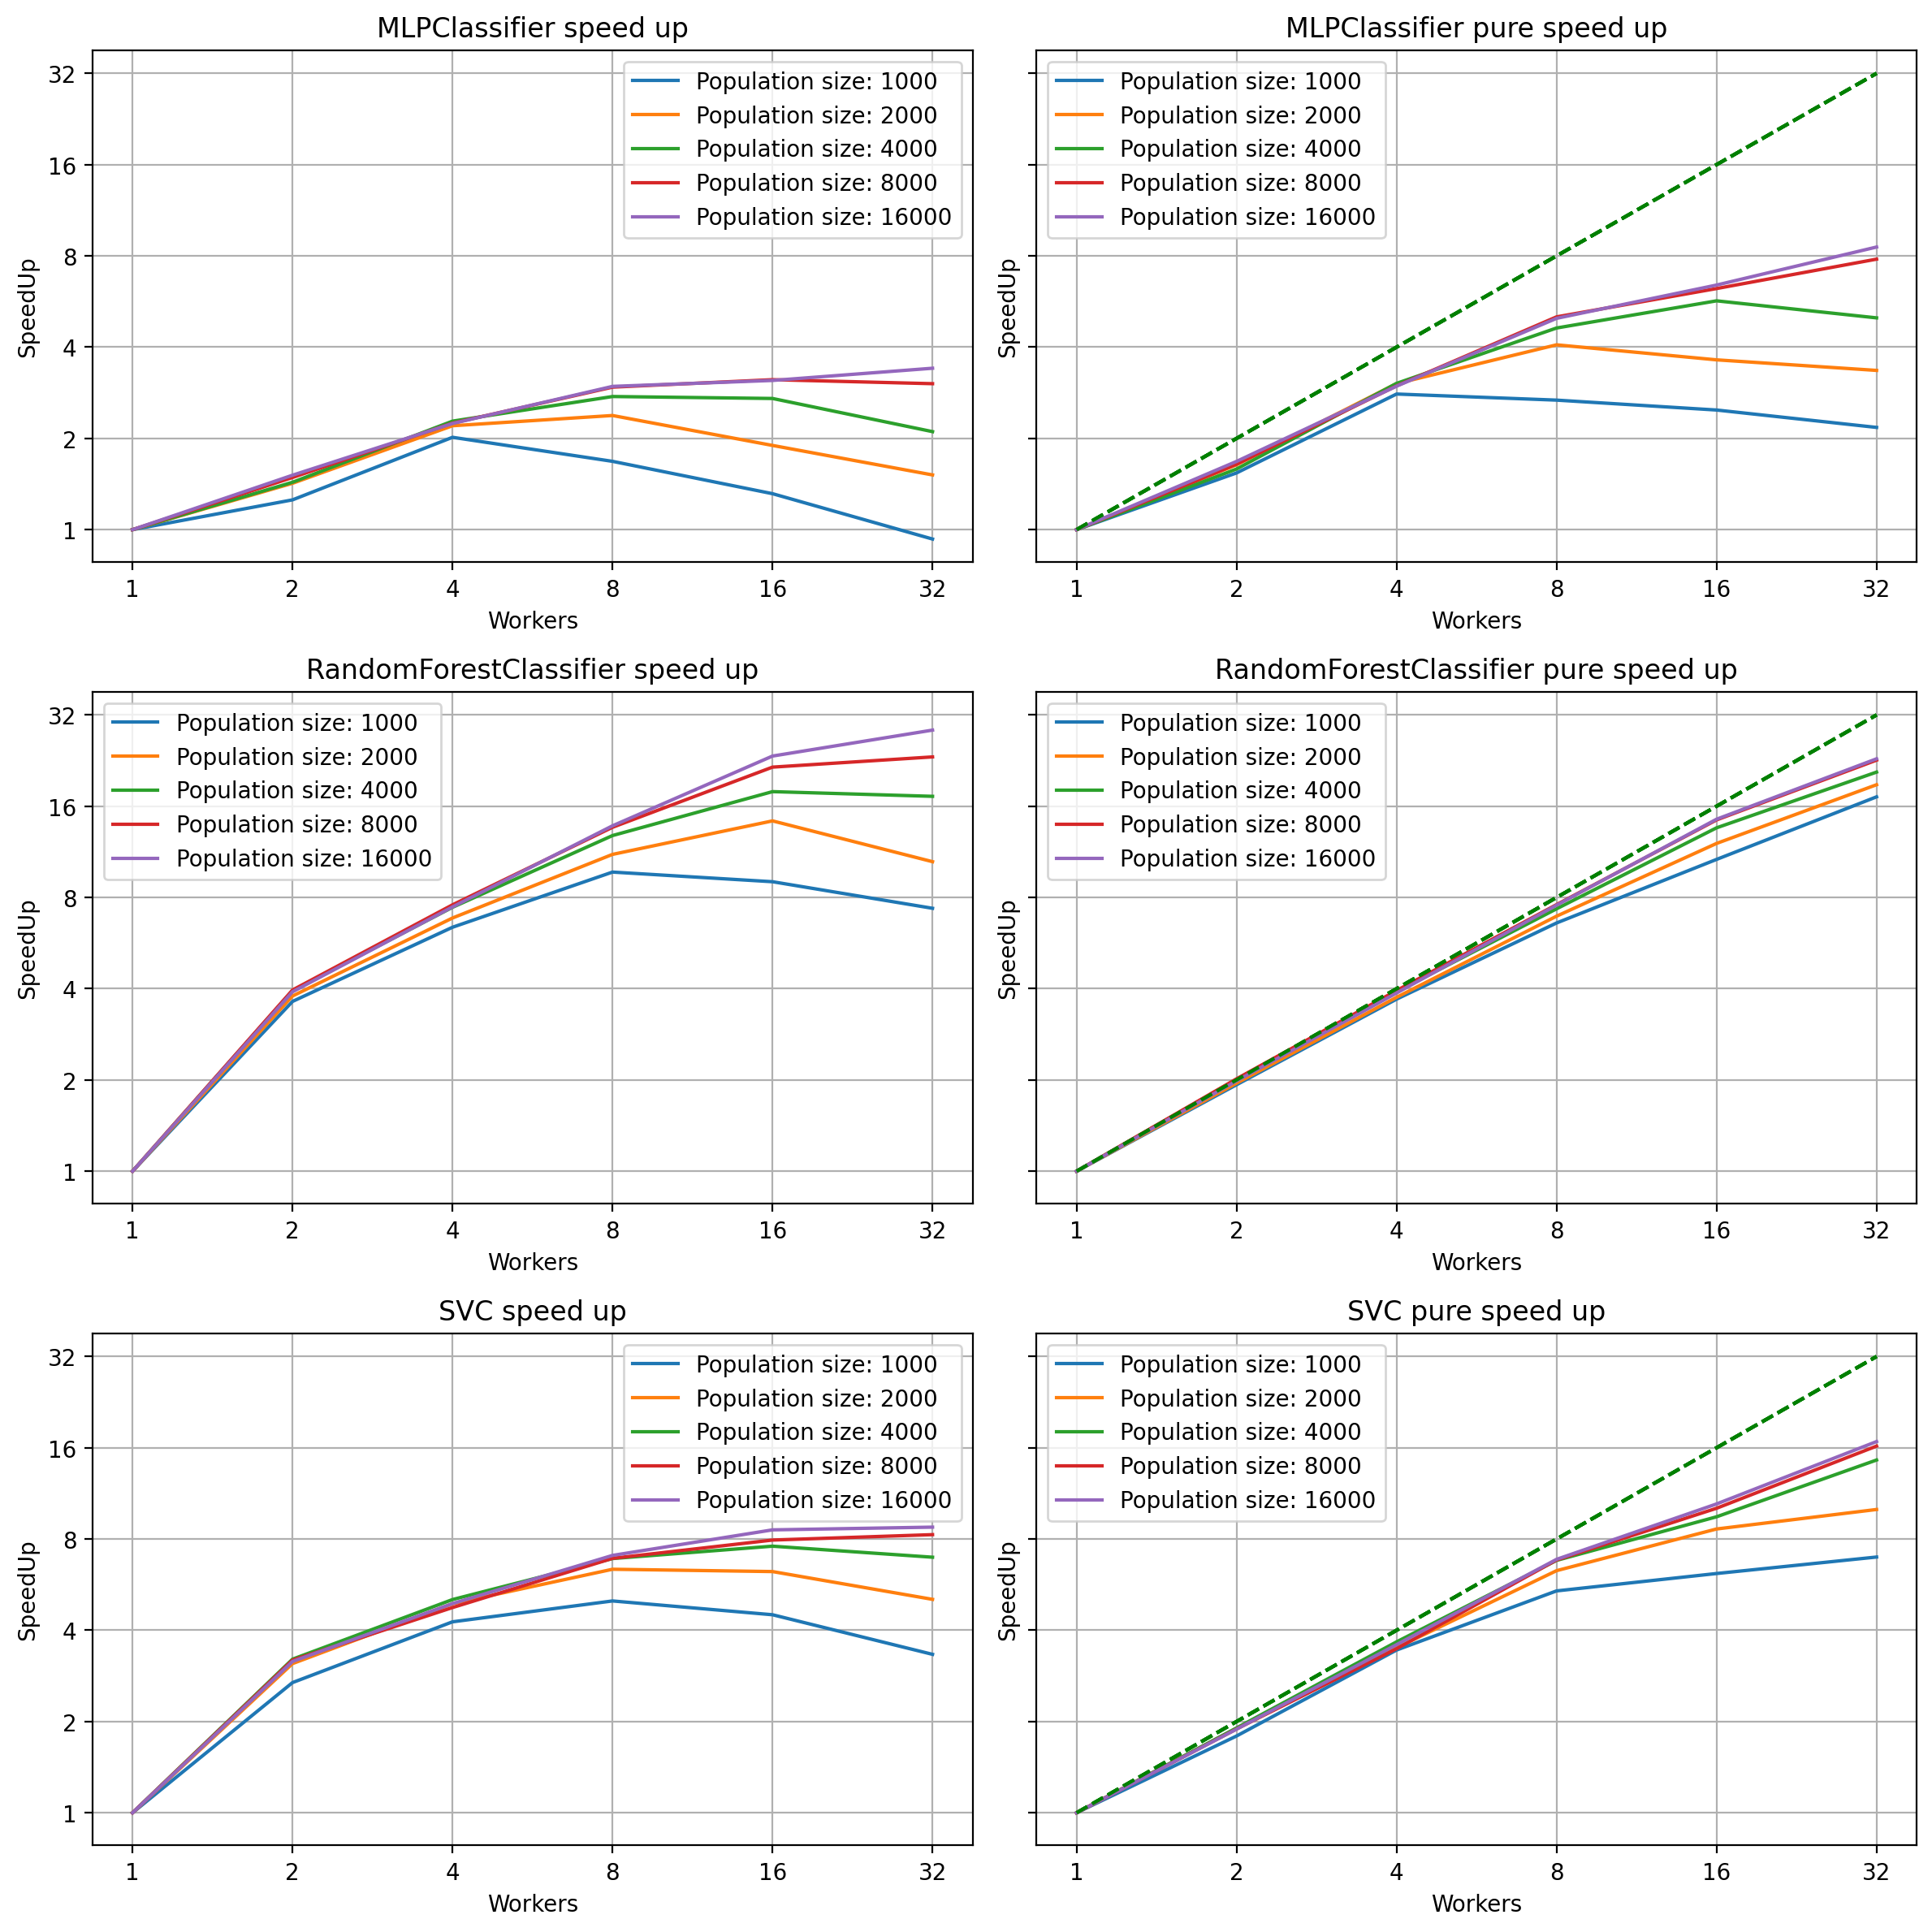

In [6]:
def plot_speedup(df):
    models = df["classifier"].unique()
    workers = df["workers"].unique()
    population_sizes = df["population_size"].unique()

    fig, axes = plt.subplots(len(models), 2, sharey=True, figsize=(12, 12), dpi=200)

    for i, model in enumerate(models):
        for ps in population_sizes:
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            axes[i, 0].set_title(f"{model} speed up")
            axes[i, 0].set_xlabel("Workers")
            axes[i, 0].set_ylabel("SpeedUp")
            axes[i, 0].plot(
                workers,
                df[mask]["speed_up"].to_numpy(),
                label=f"Population size: {ps}",
            )

            axes[i, 0].set_xscale("log", base=2)
            axes[i, 0].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i, 0].grid()
            axes[i, 0].legend()

            axes[i, 1].set_title(f"{model} pure speed up")
            axes[i, 1].set_xlabel("Workers")
            axes[i, 1].set_ylabel("SpeedUp")
            axes[i, 1].plot(
                workers,
                df[mask]["p_speed_up"],
                label=f"Population size: {ps}",
            )
            axes[i, 1].plot(workers, workers, "g--")

            axes[i, 1].set_xscale("log", base=2)
            axes[i, 1].set_yscale("log", base=2)
            axes[i, 1].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i, 1].set_yticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i, 1].grid()
            axes[i, 1].legend()

    plt.tight_layout()
    plt.show()


plot_speedup(ppga_df)

In [7]:
mlp = pd.read_csv("../results/performance/deap_MLPClassifier_pop_final4.csv")
svm = pd.read_csv("../results/performance/deap_SVC_pop_final3.csv")
rf = pd.read_csv("../results/performance/deap_RandomForestClassifier_pop_final2.csv")

deap_df = pd.concat([mlp, svm, rf], axis=0)
deap_df = (
    deap_df.groupby(by=["classifier", "population_size", "workers"])
    .mean()[["time", "ptime"]]
    .sort_values(by=["classifier", "population_size", "workers"])
    .reset_index()
)

deap_df

,classifier,population_size,workers,time,ptime
0,MLPClassifier,1000,1,4.043473,1.618883
1,MLPClassifier,1000,2,4.125577,1.547968
2,MLPClassifier,1000,4,4.151705,1.601686
3,MLPClassifier,1000,8,4.330798,1.785794
4,MLPClassifier,1000,16,4.901451,2.120141
...,...,...,...,...,...
85,SVC,16000,2,313.098080,25.677500
86,SVC,16000,4,298.354721,13.822500
87,SVC,16000,8,291.640669,7.605000
88,SVC,16000,16,290.412387,4.720000


In [8]:
deap_df = compute_speedup(deap_df, "time")
deap_df = compute_speedup(deap_df, "ptime")
deap_df

,classifier,population_size,workers,time,ptime,speed_up,p_speed_up
0,MLPClassifier,1000,1,4.043473,1.618883,1.000000,1.000000
1,MLPClassifier,1000,2,4.125577,1.547968,0.980099,1.045812
2,MLPClassifier,1000,4,4.151705,1.601686,0.973931,1.010737
3,MLPClassifier,1000,8,4.330798,1.785794,0.933655,0.906534
4,MLPClassifier,1000,16,4.901451,2.120141,0.824954,0.763574
...,...,...,...,...,...,...,...
85,SVC,16000,2,313.098080,25.677500,1.139958,1.858804
86,SVC,16000,4,298.354721,13.822500,1.196290,3.453026
87,SVC,16000,8,291.640669,7.605000,1.223831,6.276061
88,SVC,16000,16,290.412387,4.720000,1.229007,10.112171


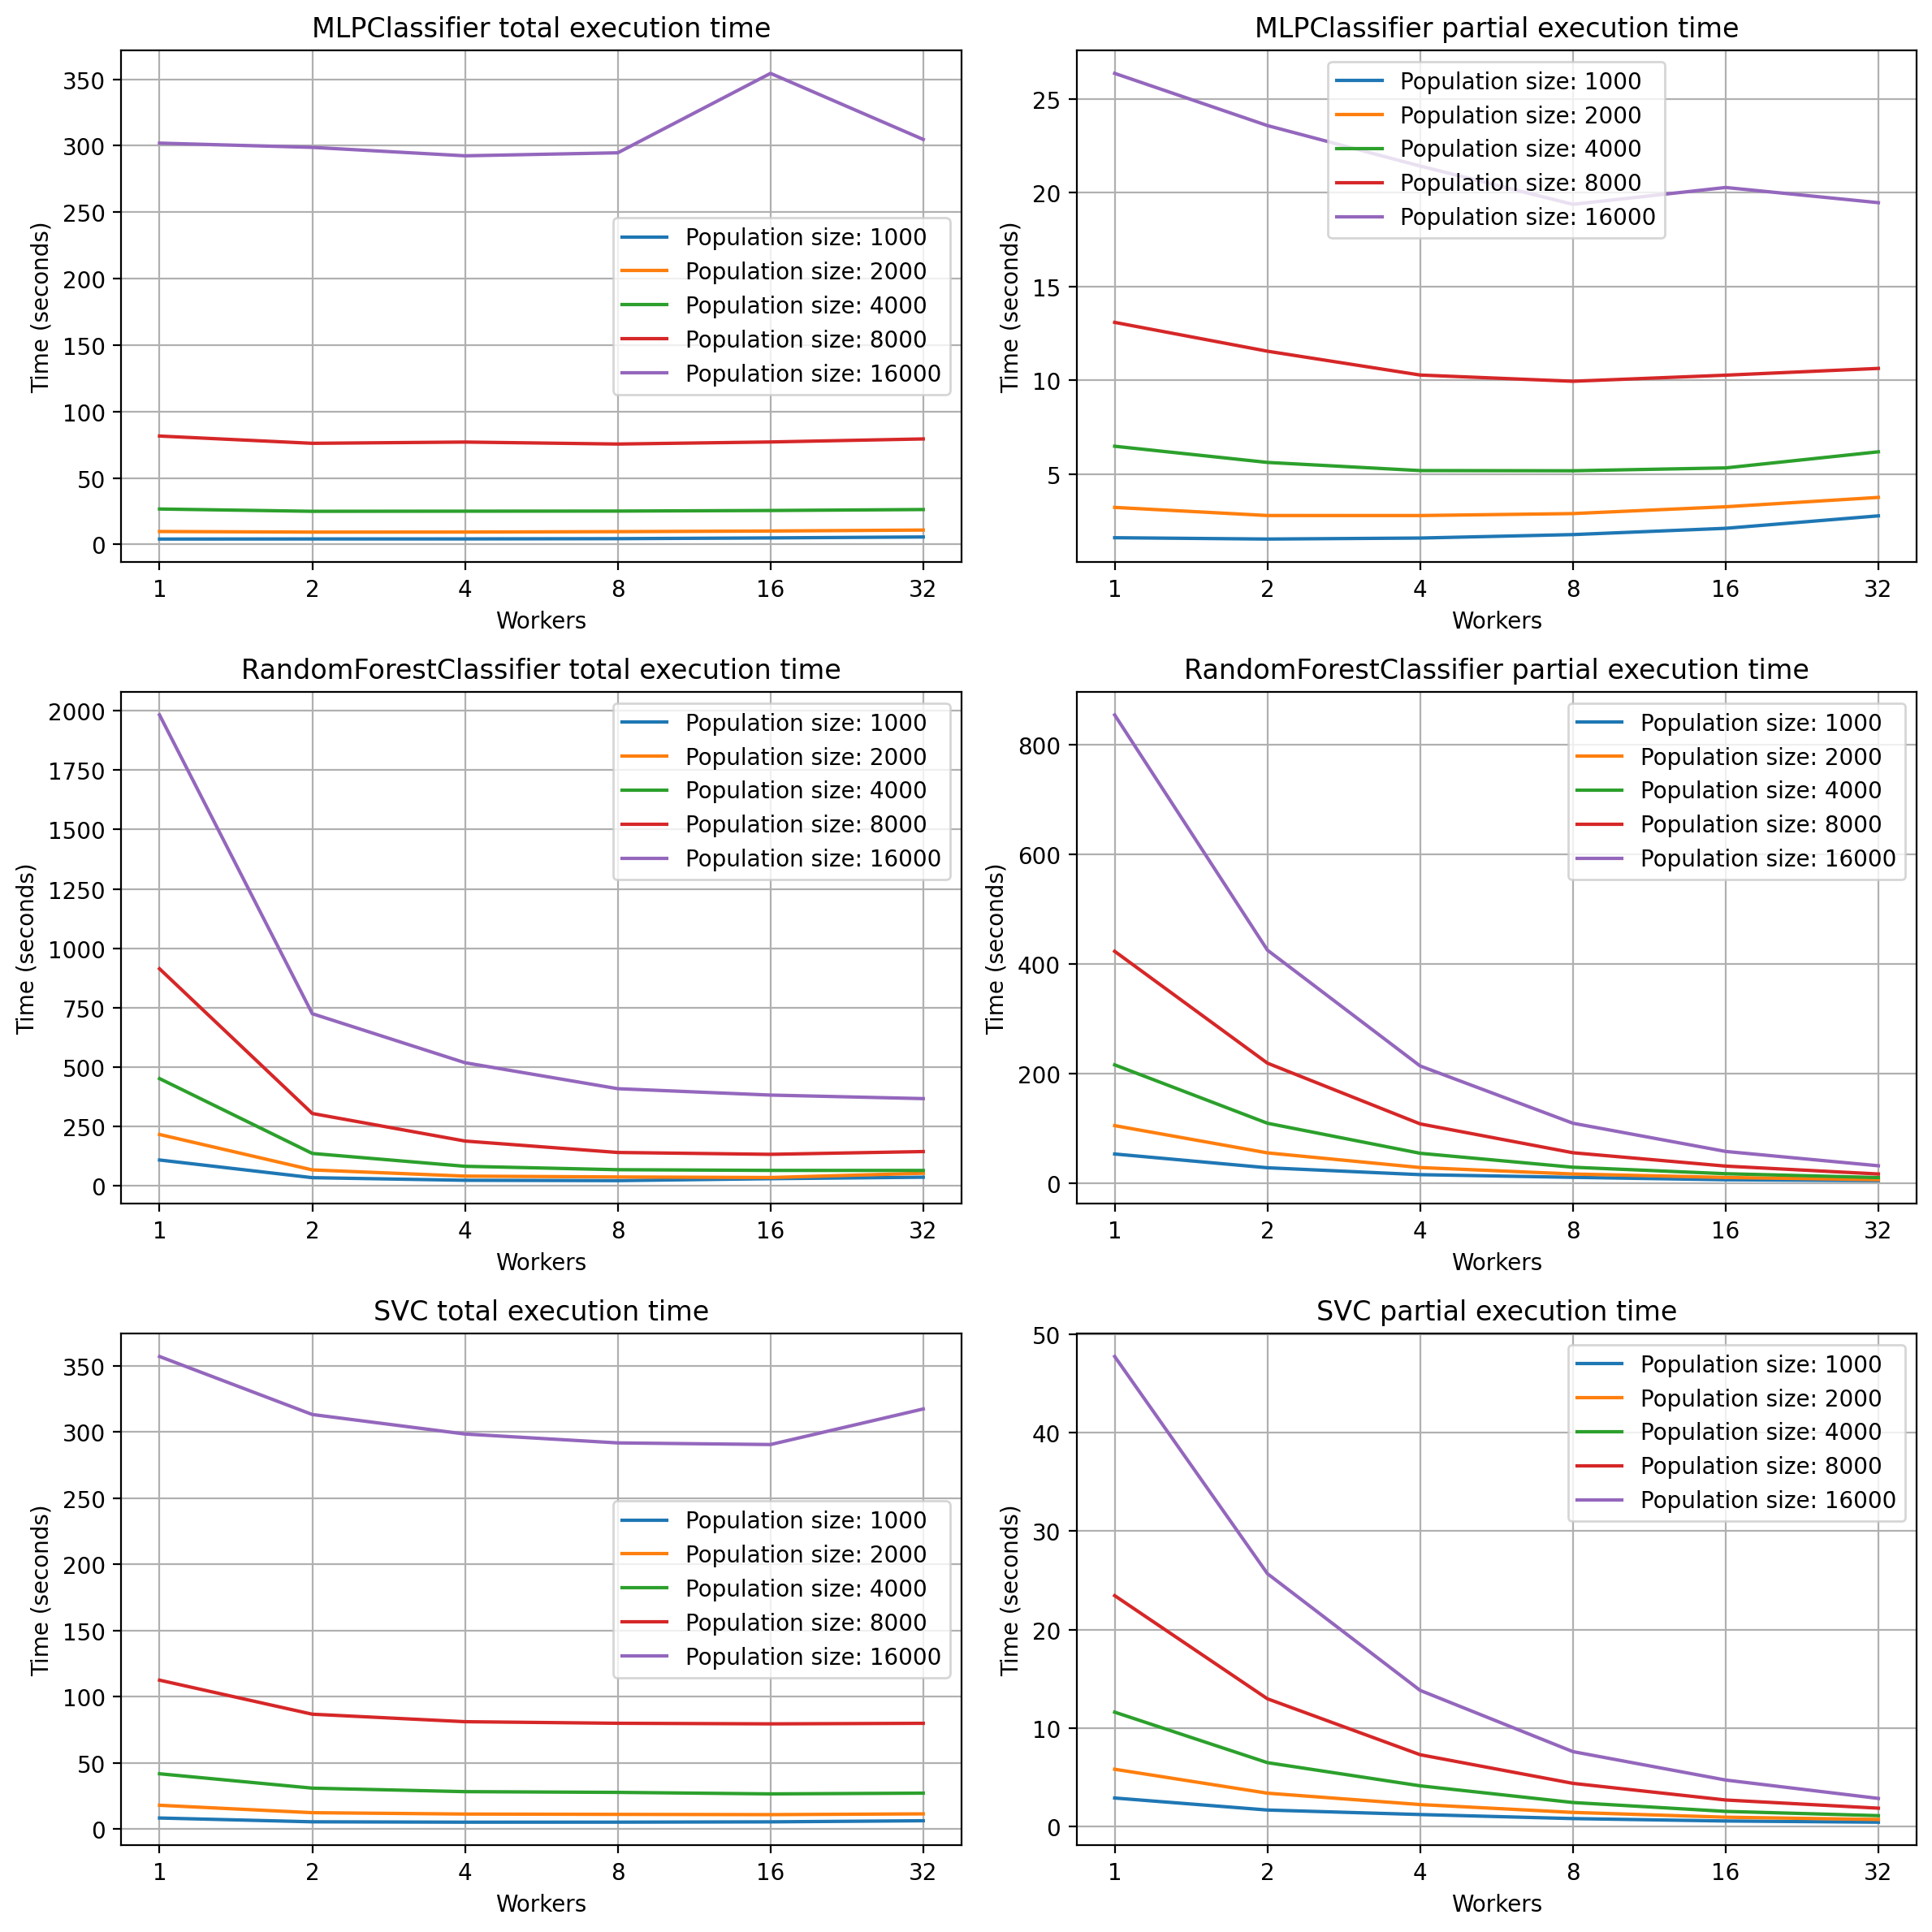

In [9]:
plot_time(deap_df)

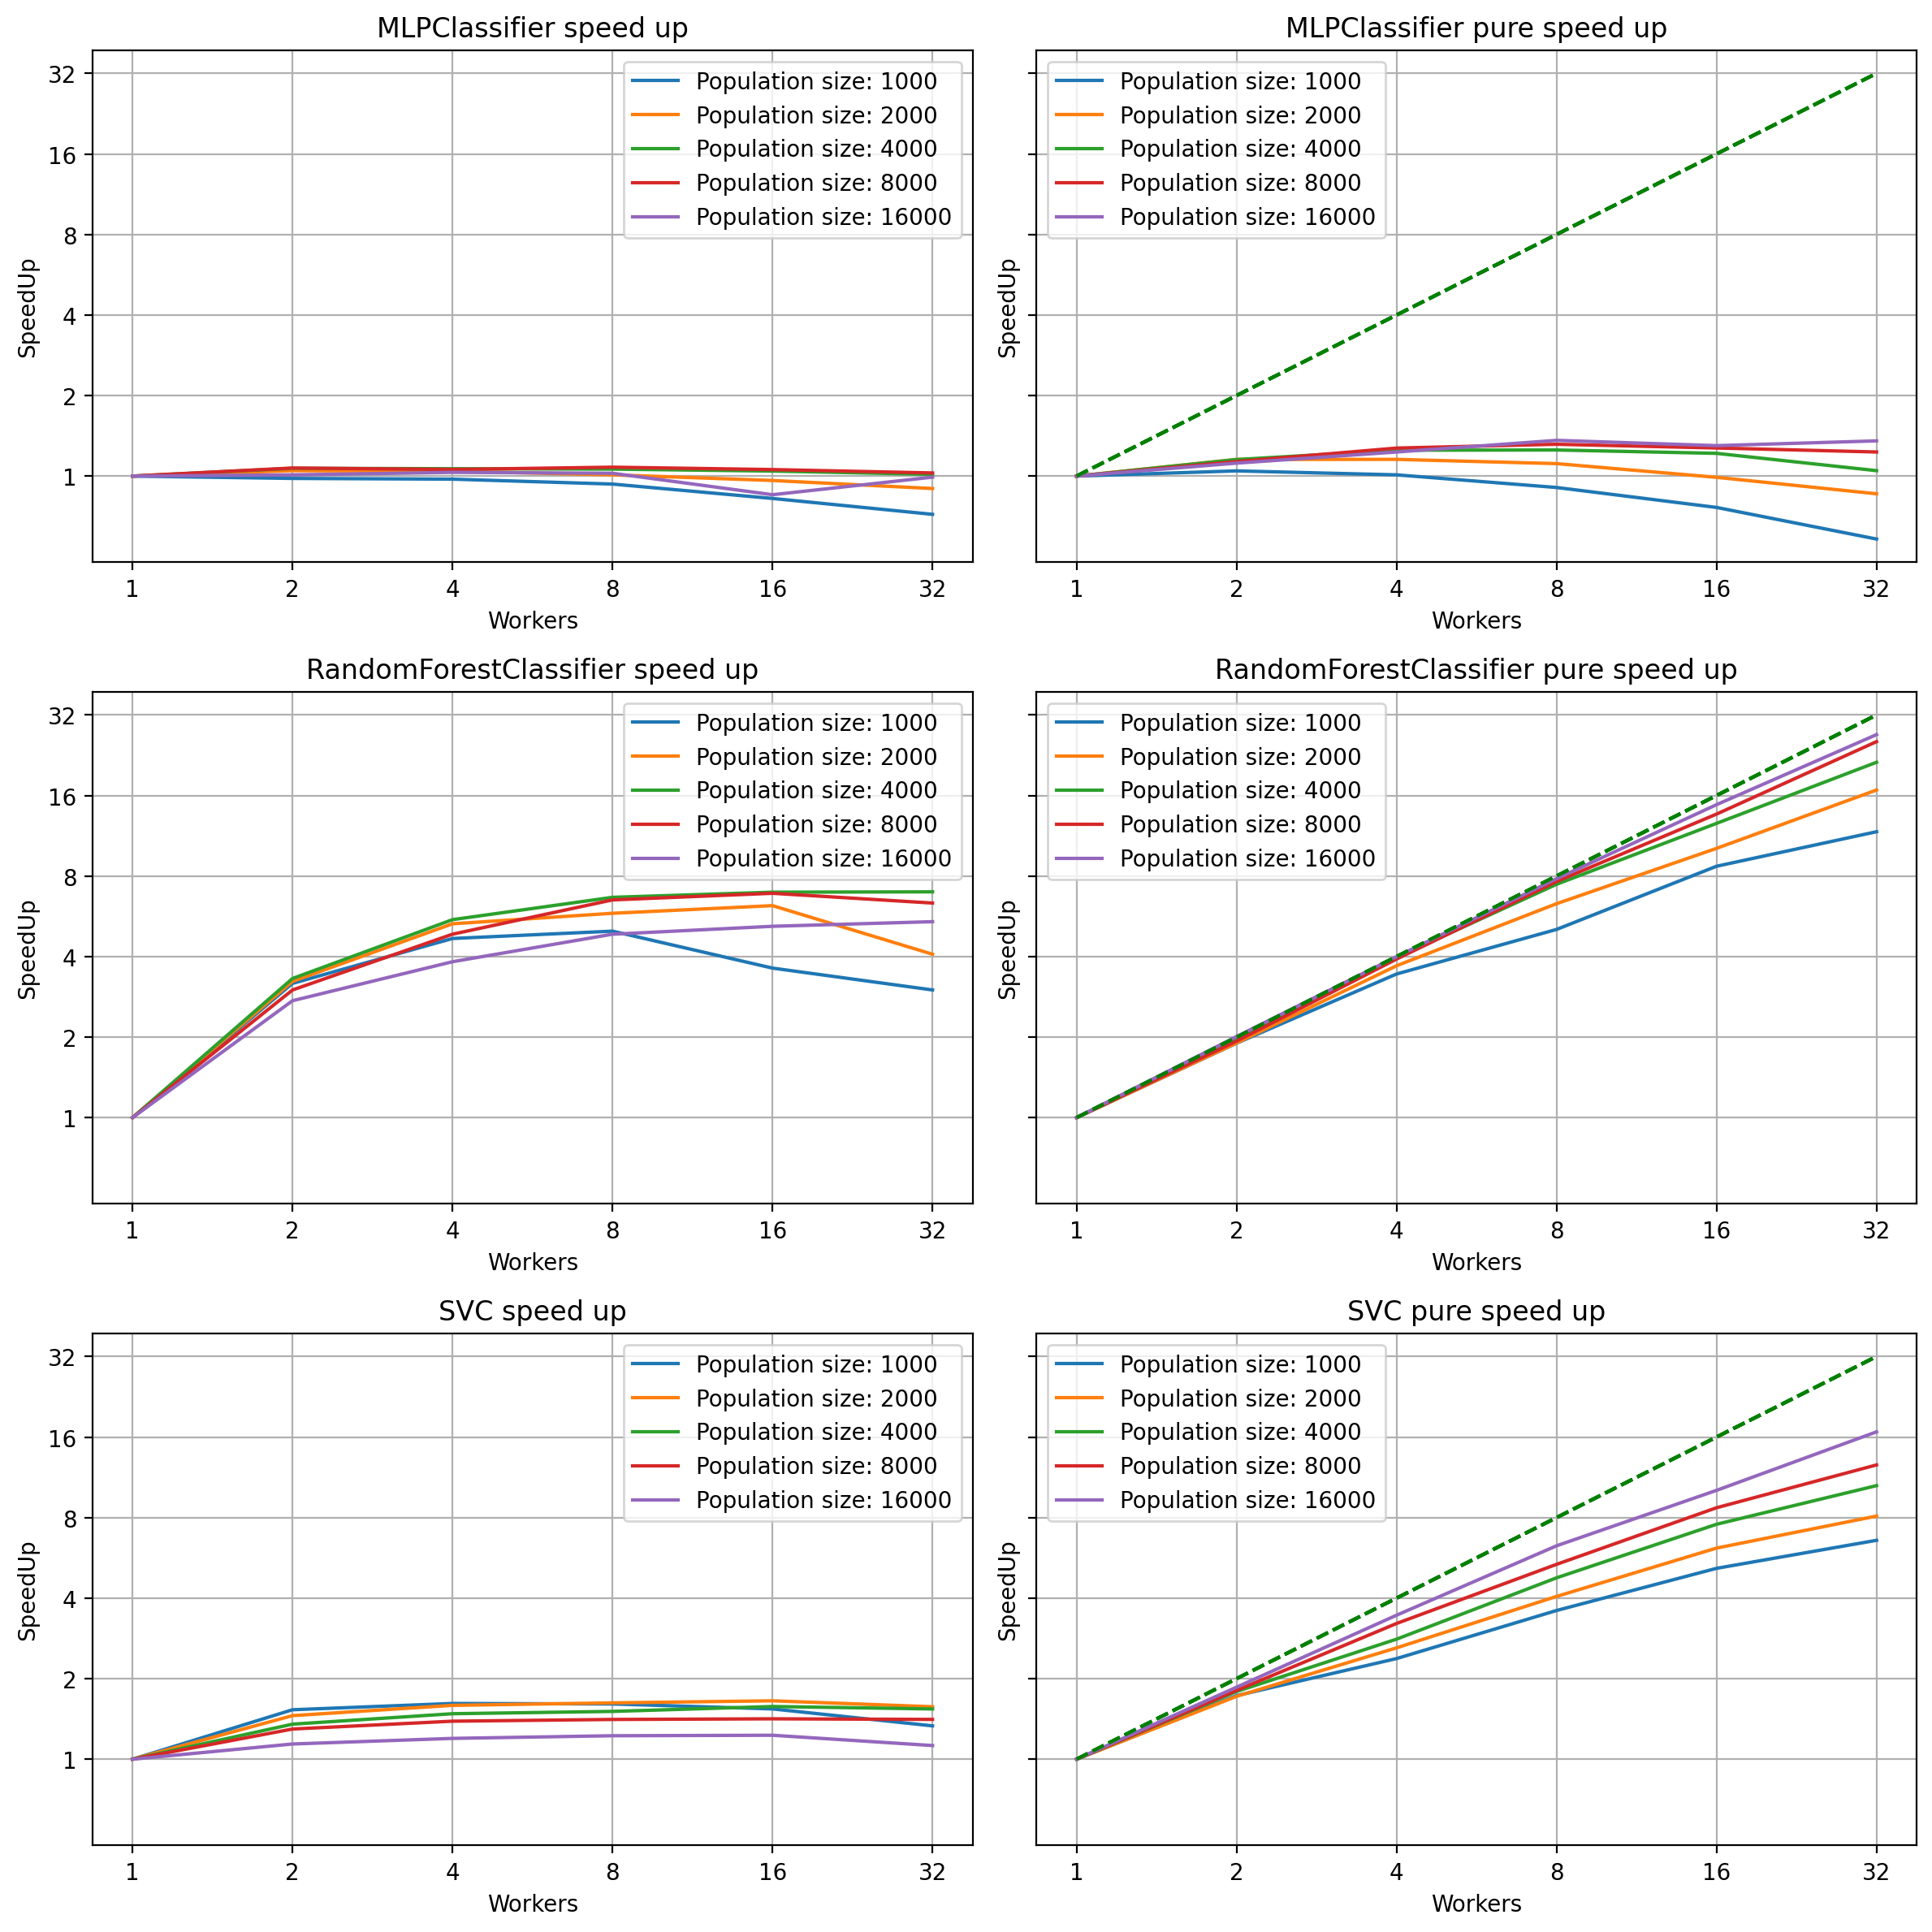

In [10]:
plot_speedup(deap_df)